# A simple benchmark example

Refer to the [tutorial page](Tutorial.md) for more insight

In [11]:
from plumed_bench_pp.parser import parse_full_benchmark_output
from plumed_bench_pp.tabulate import convert_to_table
from plumed_bench_pp.plot import plot_histo
import plumed_bench_pp.constants as plmdbppconst
import plumed_bench_pp.utils as plmdbpputils
import matplotlib.pyplot as plt
import numpy as np
nthreads=[1,2,4,6,8,10,12]

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys

    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

### the switcing function
`plumed plotswitch -h` will return:

```
Usage: plotswitch [options] 


The following arguments are compulsory: 

               --switch - ( default=RATIONAL NN=6 R_0=1.0 ) the input to pass to the 
                          switching function, please remeber the quotes 
                --steps - ( default=50 ) the number of steps between 0 and R_O, or in 
                          the specified interval 
                 --from - ( default=-1 ) the start of the interval, if negative will 
                          be set to 0 
                   --to - ( default=-1 ) the end of the interval, will be D_MAX or 
                          2*R_0 if D_MAX is not set 
        --plotprecision - ( default=8 ) the precision to use for the tabulated 
                          results 
          --rationalR_0 - ( default=-1 ) The r_0 parameter of the switching function, 
                          this will activate the --rational options, note that this will 
                          ignore the --switch option silently 
           --rationalNN - ( default=6 ) The n parameter of the switching function 
           --rationalMM - ( default=0 ) The m parameter of the switching function; 0 
                          implies 2*NN 
          --rationalD_0 - ( default=0.0 ) The d_0 parameter of the switching function 
          --centerrange - ( default=-1 ) centers the visualization in R_0 in a range 
                          given epsilons times r_0, note that specifying this will overide 
                          all the other range options 

In addition you may use the following options: 

              --help/-h - ( default=off ) print this help 
             --nosquare - ( default=off ) use calculate instead of calculateSqr 
```

Now we will use plotswitch for visualizing the swithcing function that we are going to use

```bash
plumed plotswitch --switch="EXP D_0=1 R_0=0.25 D_MAX=2" --steps=200 > ./run/switchExp.out
plumed plotswitch --rationalR_0 --steps=200 > ./run/switchR_0eq1.out
```

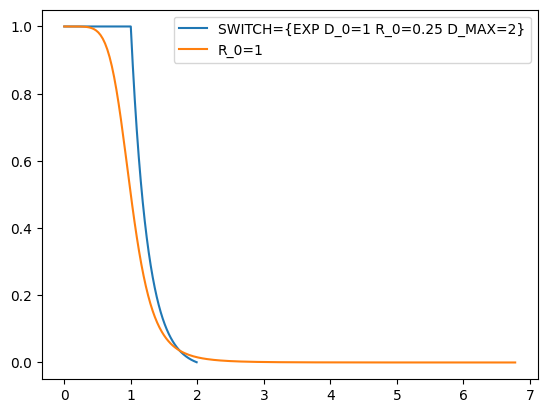

In [12]:

switchexp=np.loadtxt("./run/switchExp.out")
rationalswitch=np.loadtxt("./run/switchR_0eq1.out")

plt.plot(switchexp[:,0],switchexp[:,1],label="SWITCH={EXP D_0=1 R_0=0.25 D_MAX=2}")
plt.plot(rationalswitch[:,0],rationalswitch[:,1],label="R_0=1")

plt.legend()

The benchmark are run with the following plumed.dat file:

```plumed
cpu: COORDINATION GROUPA=@mdatoms R_0=1

PRINT ARG=* FILE=Colvar FMT=%8.4f STRIDE=1

FLUSH STRIDE=1

```

and we use the following script for the running the benchmark:
```bash
export PLUMED_MAXBACKUP=0
cd run
for nt in 1 2 4 6 8 10 12; do
    export PLUMED_NUM_THREADS=$nt
    for nat in 100 500 1000; do
        plumed benchmark --nsteps=500 --natoms=$nat --atom-distribution=sc > "./run/sc_${nt}_${nat}.out"
    done
done
```
the plumed*.dat files are in the "run" directory of the support repository

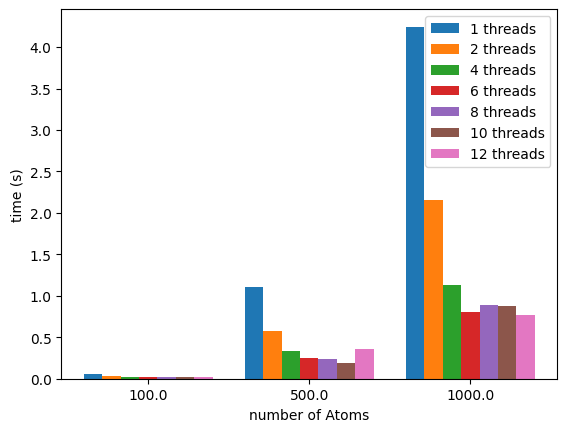

In [13]:
#bash script to prepare the data to be plotted
!for threads in 1 2 4 6 8 10 12; do \
    { for natoms in 100 500 1000; do \
        echo -n "$natoms ";\
        fname="./run/sc_${threads}_${natoms}.out";\
        sed -n '/PLUMED: *Cycles *Total *Average *Minimum *Maximum/{n ; p}' "${fname}" | \
        awk '{printf "%f ", $3}';\
        echo "";\
        done;\
    } > "./run/times_${threads}.out";\
done

simPerThread={}
for threads in nthreads:
    simPerThread[threads]=np.loadtxt(f"./run/times_{threads}.out")
fig,ax =plt.subplots()

ncols = len(simPerThread)
x = simPerThread[nthreads[0]][:,0]
x_coord=np.arange(len(x))
width = 0.8/ncols
ax.set_xticks(x_coord + width * 0.5 * (ncols - 1), x)

for multiplier, nt in enumerate(nthreads):
    offset = width * multiplier

    toplot = simPerThread[nt][:,1]
    ax.bar(
            x_coord + offset,
            toplot,
            width,
            label=f"{nt} threads",
        )
       
ax.legend()
ax.set_xlabel("number of Atoms")
_=ax.set_ylabel("time (s)")

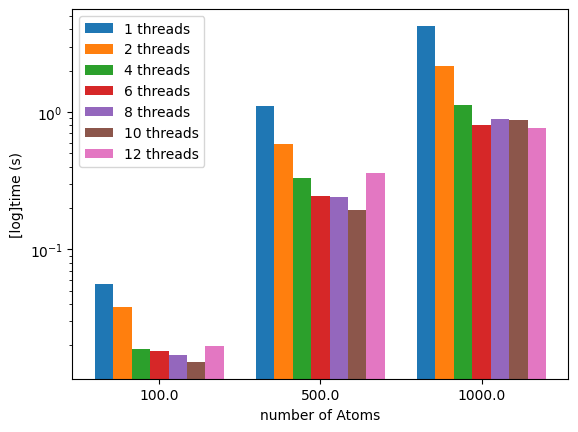

In [14]:
simPerThread={}
for threads in nthreads:
    simPerThread[threads]=np.loadtxt(f"./run/times_{threads}.out")
fig,ax =plt.subplots()

ncols = len(simPerThread)
x = simPerThread[nthreads[0]][:,0]
x_coord=np.arange(len(x))
width = 0.8/ncols
ax.set_xticks(x_coord + width * 0.5 * (ncols - 1), x)

for multiplier, nt in enumerate(nthreads):
    offset = width * multiplier

    toplot = simPerThread[nt][:,1]
    ax.bar(
            x_coord + offset,
            toplot,
            width,
            label=f"{nt} threads",
        )
       
ax.legend()
ax.set_xlabel("number of Atoms")
ax.set_yscale("log")
_=ax.set_ylabel("[log]time (s)")

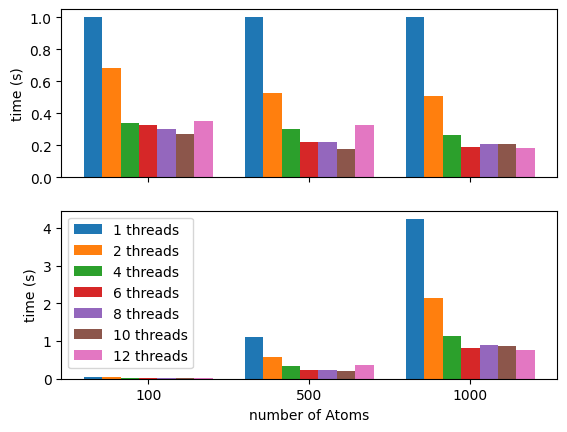

In [15]:
benchmarks={}

for threads in nthreads:
    benchmarks[threads]=[]
    for atoms in [100, 500, 1000]:
        with open(f"./run/sc_{threads}_{atoms}.out") as f:
            benchmarks[threads].append(parse_full_benchmark_output(f.readlines()))

t=[]
for threads in nthreads:
    t.append(convert_to_table(benchmarks[threads],kernel="this",inputlist=".dat",rows_to_extract=[plmdbppconst.TOTALTIME]))
fig,axes =plt.subplots(2,1,sharex=True)
plot_histo(axes[0],t,plmdbppconst.TOTALTIME, titles=[f"{threads} threads" for threads in nthreads],relative_to=0)
plot_histo(axes[1],t,plmdbppconst.TOTALTIME, titles=[f"{threads} threads" for threads in nthreads])

axes[1].set_xlabel("number of Atoms")
axes[1].legend()
for ax in axes:
    ax.set_ylabel("time (s)")



```bash
export PLUMED_MAXBACKUP=0
export PLUMED_NUM_THREADS=8
cd run
for nat in 500 1000 2000; do
    plumed benchmark --nsteps=500 \
        --natoms=$nat \
        --plumed="plumed.dat:plumedNL110_shortstride.dat:plumedNL150_shortstride.dat:plumedNL200_shortstride.dat" \
        --atom-distribution=sc > sc_NL_shortstride_${nat}.out

    plumed benchmark --nsteps=500 \
        --natoms=$nat \
        --plumed="plumed.dat:plumedNL110.dat:plumedNL150.dat:plumedNL200.dat" \
        --atom-distribution=sc > sc_NL_${nat}.out
done

```
the plumed*.dat files are in the "run" directory of the support repository

Text(0, 0.5, 'time/(time no NL)')

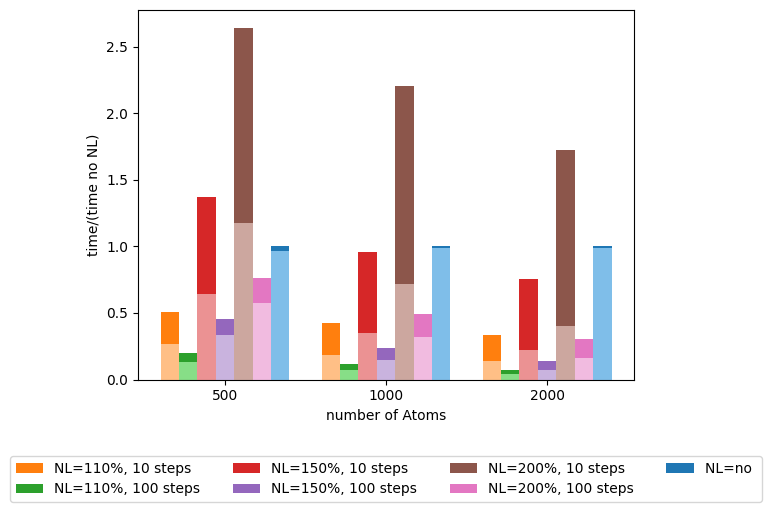

In [17]:
benchmarks=[]

#preload the full files in memory
for atoms in [500, 1000, 2000]:
    with open(f"./run/sc_NL_all_{atoms}.out") as f:
        benchmarks.append(parse_full_benchmark_output(f.readlines()))

#extract the rows we want to plot from the preloaded files
rows_to_extract=[plmdbppconst.TOTALTIME,plmdbppconst.CALCULATE]
t=[]

for perc in [110, 150, 200]:
    t.append(convert_to_table(benchmarks,kernel="this",inputlist=f"plumedNL{perc}_shortstride.dat",rows_to_extract=rows_to_extract))
    t.append(convert_to_table(benchmarks,kernel="this",inputlist=f"plumedNL{perc}.dat",rows_to_extract=rows_to_extract))
t.append(convert_to_table(benchmarks,kernel="this",inputlist="plumed.dat",rows_to_extract=rows_to_extract))

#these are the label of the columns
NL=["110%, 10 steps" , "110%, 100 steps", "150%, 10 steps", "150%, 100 steps", "200%, 10 steps", "200%, 100 steps","no"]
#plot the histogram with a fancy layout
fig,ax =plt.subplots()
colors=[f"C{i}" for i in range(1,len(t))]+["C0"]
lc=[lighten_color(c) for c in colors]
plot_histo(ax,t,plmdbppconst.TOTALTIME, titles=[f"NL={nl} " for nl in NL],relative_to=-1,colors=colors) 
plot_histo(ax,t,plmdbppconst.CALCULATE, relative_to=-1, relative_to_row=plmdbppconst.TOTALTIME,colors=lc) 

ax.set_xlabel("number of Atoms")
ax.legend(ncols=4,loc="lower center", bbox_to_anchor=(0.5, -0.35))
ax.set_ylabel("time/(time no NL)")


### Extra cache:
It felt strange to see that the calculate part of the simulation is different intuitively it should be identical, since "sc" is a fixed shaped system, so I added an extra run and I looked at the minimimum, the maximum and the average.

I think the discrepancy is due to the cpu loading and unloading the instruction for the calculation of the NL or of the coordination that that could bring in cache misses.
In these examples the mimimum and the maximum are quite similar, but the average is higher in the runs with the NL caclulated every fewer steps

The bars span from minimum time to maximum time registered by the plumed timer.

(the data has been loaded by the previous cell)

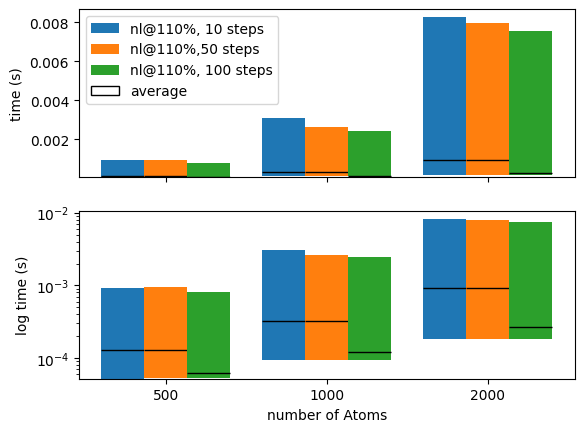

In [19]:
t=[]
t.append(convert_to_table(benchmarks,
                 kernel="this",
                 inputlist="plumedNL110_shortstride.dat",
                 rows_to_extract=[plmdbppconst.CALCULATE]))
t.append(convert_to_table(benchmarks,
                 kernel="this",
                 inputlist="plumedNL110_mediumstride.dat",
                 rows_to_extract=[plmdbppconst.CALCULATE]))
t.append(convert_to_table(benchmarks,
                 kernel="this",
                 inputlist="plumedNL110.dat",
                 rows_to_extract=[plmdbppconst.CALCULATE]))
fig,axes =plt.subplots(2,1,sharex=True)

ncols = 3
x = [500,1000,2000]
x_coord=np.arange(len(x))
width = 0.8/ncols
Labels=["nl@110%, 10 steps", "nl@110%,50 steps", "nl@110%, 100 steps"]
for ax in axes:
    ax.set_xticks(x_coord + width * 0.5 * (ncols - 1), x)
    for multiplier, df in enumerate(t):
        offset = width * multiplier

        toplot = simPerThread[nt][:,1]
        ax.bar(
                x_coord + offset,
                df[plmdbppconst.CALCULATE].Maximum.values-df[plmdbppconst.CALCULATE].Minimum.values,
                width,
                bottom=df[plmdbppconst.CALCULATE].Minimum.values,
                color=[f"C{multiplier}"],
                label=Labels[multiplier]
                )
        ax.bar(
                x_coord + offset,
                0,
                width,
                bottom=df[plmdbppconst.CALCULATE].Average.values,
                fill=False,
                label="average" if multiplier==2 else None
                )
axes[0].set_ylabel("time (s)")
axes[1].set_ylabel("log time (s)")
axes[1].set_xlabel("number of Atoms")
axes[1].set_yscale("log")
_=axes[0].legend()